In [325]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import xml.etree.ElementTree as ET
import pickle
%matplotlib inline
num_cpu = 64
clientCPU = range(0,16)
serverCPU = range(16,24)
idle_times={}
for i in range(num_cpu):
    idle_times[i]=[]
    
outputfolder = "22_aug/8_core_perf"
outputfolder = "output_arm"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
perfFile = outputfolder+"/perf.txt"
with open(utilFile) as f:
    utilBigList = f.read().split("@")[1:]

for utilSingle in utilBigList:
    idle_times_temp = {}
    for i in range(num_cpu):
        idle_times_temp[i]=[]
    stringNewLine = utilSingle.split('\n')[2:]
    for stringLine in stringNewLine:        
        words = stringLine.split()
        if(len(words)>=2 and words[1].isdigit()):
            CPU = int(words[1])
            idle = float(words[-1].rstrip('\x00'))
            idle_times_temp[CPU].append(idle)
    for i in range(num_cpu):
        idle_times[i].append(idle_times_temp[i])
idle_times_avg = {}
for i in range(num_cpu):
    idle_times_avg[i]=[]
    for times in idle_times[i]:
        idle_times_avg[i].append(np.mean(times))
#         if np.isnan(np.mean(times)):
#             print(times)
#             print(np.mean(times))
#print(idle_times_avg)

with open(operationsFile) as f:                                                                                                                                                                                     
    operationsStr = f.read().split('\n')[:-1]
operations = np.array(map(int, operationsStr))
def show(elem):
    print elem.tag
    for child in elem.findall('*'):
        show(child)
        
        
def readPerf(perfFile):
    instructionsU = []
    instructionsK = []
    cycles = []
    with open(perfFile) as f:
        lines = f.readlines()
        for line in lines:
            if re.search('instructions:u', line, re.I):
                instructionsU.append(float(line.split()[0]))
            if re.search('instructions:k', line, re.I):
                instructionsK.append(float(line.split()[0]))
            if re.search('cycles', line, re.I):
                cycles.append(float(line.split()[0]))
    instructionsU = np.array(instructionsU)
    instructionsK = np.array(instructionsK)
    cycles = np.array(cycles)
    ipcU = instructionsU/cycles
    ipcK = instructionsK/cycles
    ipcTotal = ipcU + ipcK
    return {
        "instructionsU":instructionsU,
        "instructionsK":instructionsK,
        "cycles":cycles,
        "ipcU":ipcU,
        "ipcK":ipcK,
        "ipcTotal":ipcTotal
    }
# readPerf(perfFile)
                
                
def readBenchmark(benchmarkFile):
    xmlList = []
    start = 0
    with open(benchmarkFile) as f:
        content = f.read()
        while(True):
            a = ( string.find(content,"<benchResults>"))
            
            b = ( string.find(content[start:],"</benchResults>")) + len("</benchResults>")

            if (a is not -1 and b is not -1):
                xmlList.append(content[a:b])
                content = content[b:]
            else:
                break
    avg = []
    p90th = []
    p99th = []
    totalOps = []
    throughput = []
    for xml in xmlList:
        benchResult = ET.fromstring(xml)
        driverSummary = benchResult.find("driverSummary")
        avg.append(float(driverSummary.find("responseTimes/operation/avg").text))
        p90th.append(float(driverSummary.find("responseTimes/operation/p90th").text.replace('>','')))
        p99th.append(float(driverSummary.find("responseTimes/operation/p99th").text.replace('>','')))
        totalOps.append(float(driverSummary.find("totalOps").text))
        throughput.append(float(driverSummary.find("metric").text))
    return {
        "avg":avg,
        "p90th":p90th,
        "p99th":p99th,
        "totalOps":totalOps,
        "throughput":throughput
    }
    

    
    
    
    
    
    
    


results = readBenchmark(benchmarkFile)
for result in results:
    print("{}:{}".format(result,results[result]))
for cpu in idle_times_avg:
    idle_times_avg[cpu] = np.array(idle_times_avg[cpu])

   




p90th:[0.15, 2.475, 2.475, 0.235, 0.115, 0.118, 2.475, 0.18, 2.475, 0.105, 0.133, 2.475, 2.475, 0.108, 0.215, 0.12, 0.113, 2.475, 2.475, 0.113, 2.475, 0.23, 0.118, 2.475, 0.12, 2.475]
avg:[0.059, 2.835, 1.925, 0.09, 0.045, 0.047, 1.04, 0.071, 1.759, 0.043, 0.052, 1.104, 2.342, 0.04, 0.086, 0.048, 0.044, 1.874, 2.547, 0.045, 1.091, 0.094, 0.045, 1.911, 0.047, 1.096]
throughput:[9.833, 146.833, 156.733, 158.4, 61.767, 110.633, 167.2, 159.067, 162.1, 58.667, 112.9, 166.333, 165.333, 10.6, 160.833, 110.733, 61.2, 159.2, 155.0, 9.933, 166.3, 157.667, 9.833, 157.633, 59.867, 164.533]
totalOps:[295.0, 4405.0, 4702.0, 4752.0, 1853.0, 3319.0, 5016.0, 4772.0, 4863.0, 1760.0, 3387.0, 4990.0, 4960.0, 318.0, 4825.0, 3322.0, 1836.0, 4776.0, 4650.0, 298.0, 4989.0, 4730.0, 295.0, 4729.0, 1796.0, 4936.0]
p99th:[0.275, 2.475, 2.475, 0.57, 0.235, 0.233, 2.475, 0.423, 2.475, 0.195, 0.278, 2.475, 2.475, 0.188, 0.553, 0.233, 0.23, 2.475, 2.475, 0.195, 2.475, 0.603, 0.225, 2.475, 0.235, 2.475]


In [326]:
bench1 = readBenchmark(benchmarkFile)
perf1 = readPerf(perfFile)
for x in perf1:
    bench1[x] = perf1[x]
#bench1 = readBenchmark("output/benchmark2.txt")
for i in idle_times_avg:
    idle_times_avg[i]=idle_times_avg[i][0:len(bench1["throughput"])]
operations = operations[:len(bench1["throughput"])]
util_bench = idle_times_avg[0]*0
util_server = idle_times_avg[0]*0
for i in range(num_cpu):
    if i in clientCPU:
        util_bench = util_bench + idle_times_avg[i]
    elif i in serverCPU:
        util_server = util_server + idle_times_avg[i]
util_bench = 100.0 - util_bench/len(clientCPU)
util_server = 100.0 - util_server/(len(serverCPU))
bench1["CPUUtilClient"] = util_bench
bench1["CPUUtilServer"] = util_server


In [327]:

values = ["avg","p90th","p99th","totalOps","throughput","CPUUtilClient","CPUUtilServer","instructionsU","instructionsK","cycles","ipcU","ipcK","ipcTotal"]
benchStdMean = {}
for value in values:
    benchStdMean[value] = []
operations = operations[0:len(bench1["avg"])]

unique_op={}
for i in range(len(operations)):
    if operations[i] not in unique_op:
        unique_op[operations[i]] = operations[i]
sorted_op = np.sort(unique_op.keys())
for op in sorted_op:
    ii = np.where(operations == op)[0]
    for value in values:
        benchStdMean[value].append(np.take(bench1[value],ii))
for value in values:
    benchStdMean[value+"Mean"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Mean"].append(np.mean(x)) 
    benchStdMean[value+"Std"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Std"].append(np.std(x)) 
for value in benchStdMean:
    benchStdMean[value]=np.array(benchStdMean[value])

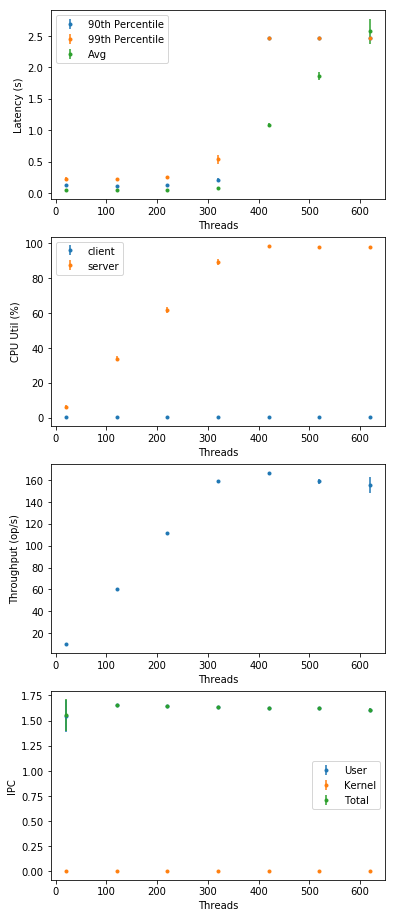

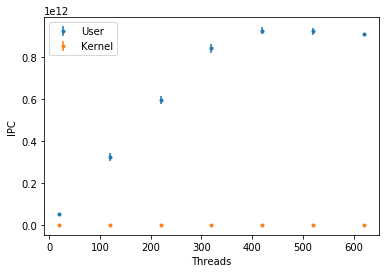

In [330]:

fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*4))


plt.subplot(4,1,1)
plt.errorbar(sorted_op,benchStdMean["p90thMean"],yerr = benchStdMean["p90thStd"],label="90th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["p99thMean"],yerr = benchStdMean["p99thStd"],label="99th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["avgMean"],yerr = benchStdMean["avgStd"],label="Avg",linestyle='None',marker=".")

plt.xlabel("Threads")
plt.ylabel("Latency (s)")
plt.legend()

plt.subplot(4,1,2)
plt.errorbar(sorted_op,benchStdMean["CPUUtilClientMean"],yerr = benchStdMean["CPUUtilClientStd"],label="client",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["CPUUtilServerMean"],yerr = benchStdMean["CPUUtilServerStd"],label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("CPU Util (%)")


plt.subplot(4,1,3)
plt.errorbar(sorted_op,benchStdMean["throughputMean"],yerr = benchStdMean["throughputStd"],label="Throughput",linestyle='None',marker=".")
plt.xlabel("Threads")
plt.ylabel("Throughput (op/s)")

plt.subplot(4,1,4)
plt.errorbar(sorted_op,benchStdMean["ipcUMean"],yerr = benchStdMean["ipcUStd"],label="User",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["ipcKMean"],yerr = benchStdMean["ipcKStd"],label="Kernel",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("IPC")

plt.savefig(outputfolder + ".png")
# plt.savefig("Web_search_result.png")
plt.show()
plt.figure(1)
plt.errorbar(sorted_op,benchStdMean["instructionsUMean"],yerr = benchStdMean["instructionsUStd"],label="User",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["instructionsKMean"],yerr = benchStdMean["instructionsKStd"],label="Kernel",linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("IPC")
plt.show()

In [332]:
print(sorted_op)
print(benchStdMean["instructionsUMean"])
print(benchStdMean["instructionsKMean"])
# for i in range(sorted_op):
#     print(""{})
# benchStdMean["p90thStd"]
# pickle.dump( benchStdMean, open( "data.dump", "wb" ) )
# pickle.dump(sorted_op,open("operations.dump","wb"))

[ 20 120 220 320 420 520 620]
[  5.38653747e+10   3.24012835e+11   5.94006126e+11   8.39924843e+11
   9.24977610e+11   9.20970287e+11   9.10717749e+11]
[  3.40351115e+08   7.12687125e+08   1.03390490e+09   1.60870256e+09
   1.54462604e+09   1.68821040e+09   2.13755486e+09]


In [320]:
benchStdMean["readLatency99Mean"]
for i in range(len(sorted_op)):
    print("{}:{}".format(sorted_op[i],benchStdMean["readLatency99Mean"][i]/benchStdMean["updateLatency99Mean"][i]))
print("Avg")
for i in range(len(sorted_op)):
    print("{}:{}".format(sorted_op[i],benchStdMean["readLatencyAvgMean"][i]/benchStdMean["updateLatencyAvgMean"][i]))    


KeyError: 'readLatency99Mean'

In [ ]:
benchStdMean["updateLatency95Mean"]

In [ ]:
import csv
x = []
x.append("Operations")
for value in sorted(benchStdMean, key=str.lower):
    x.append(value)

y = []
y.append(x)
for i in range(len(sorted_op)):
    x=[]
    x.append(sorted_op[i])
    for value in sorted(benchStdMean, key=str.lower):
        x.append(benchStdMean[value][i])
    y.append(x)
# print(len(y))
# print(y[0])
for x in zip(*y):
    print(x)
#     print("-------------------------------")
    break
# data

In [271]:
with open("new_file.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(y)